## Neural Nets ## 
This notebook is based off of [L15](https://www.youtube.com/watch?v=Z1pcTxvCOgw&list=PLruBu5BI5n4aFpG32iMbdWoRVAA-Vcso6&index=15) of David McKay's course on Info Theory, Inference, and Learning Algorithms. 





Recall that a _neuron_ within a neural net linearly combines inputs (with possibly a bias)
and then send that output through some non-linear activation function (sigmoid, ReLu etc). 
$$
a = \sum_{i=1}^{K} w_i x_i + w_o
$$
$$
y=f(a)
$$

These equations should look familiar. They have been previously shown as 
1. The Variational Free Energy (VAE) of a spin system where you took a weighted sum of the surrounding spins and put them through a $tanh()$ function 
2. Classifying a point that comes from the mixture of two gaussians-$P(c=1 | x) = f(a)$ where $f(a) = \frac{1}{1 + e^{-a}}$ and $a = \sum_{i=1}^{K} w_i x_i + w_o$

### Neurons and Training Neural Nets ### 
Now the difference between the neural network and the previous ways we have seen this set up is that we will iteratively 'learn' our way to a solution by updating our weights. The way we do that here is by calculating our loss at each iteration, and then following the gradient (with respect to weights) in a way that reduces our loss. 
Namely, we will use the _binary cross entropy_ loss function which is used typically in binary classification tasks 
$$
L(W) = -\sum_{i=1}^{N} t_i\log{y_i} + (1 - t_i)\log{1-y_i} 
$$ 
Where $t_i$ is our target (1 or 0) and $y_i$ is the output of our network. 

Let's visualize this function

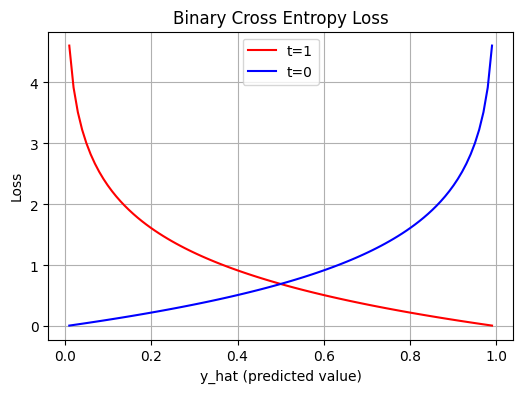

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Define the binary cross entropy loss function
def binary_cross_entropy(y_hat, t=1):
    return -t * np.log(y_hat) - (1 - t) * np.log(1 - y_hat)

# Generate a range of y_hat values
y_hat = np.linspace(0.01, 0.99, 100)

# Calculate the loss for each y_hat value
loss_1 = binary_cross_entropy(y_hat)
loss_0 = binary_cross_entropy(y_hat, 0)
# Plot the loss function
plt.figure(figsize=(6, 4))
plt.plot(y_hat, loss_1, color='r', label='t=1')
plt.plot(y_hat, loss_0, color='b', label='t=0')
plt.title('Binary Cross Entropy Loss')
plt.xlabel('y_hat (predicted value)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

So this is what it looks like - the red line would be if our target variable is 1 and the blue one if our target variable ($t_i$) is 0. 

In order to update the weights of our network, we will be following a simple gradient descent formula, where we move in the negative direction of the gradient at each step. The gradient here is 
$\frac{\partial L}{\partial W}$ and for our binary cross entropy loss function (with logistic activation) it's not too hard to show that this evaluates to 
$$
\frac{\partial L}{\partial W} = \sum_{i=1}^{N} (t_i - y_i) * x
$$

You can look [here](https://www.python-unleashed.com/post/derivation-of-the-binary-cross-entropy-loss-gradient) for a complete derivation (in the vectorized case)

OK let's train the simplest neural net in the world with two input variables and a single neuron and see how it goes ! 

1) First we will sample and display the data 
2) Then you can explore our sigmoid activation function and how it responds
to different weight values 
3) Then we will create our training samples, loop through one epoch of all samples, accumulate our gradient and update our weights (i.e 'learn'). 

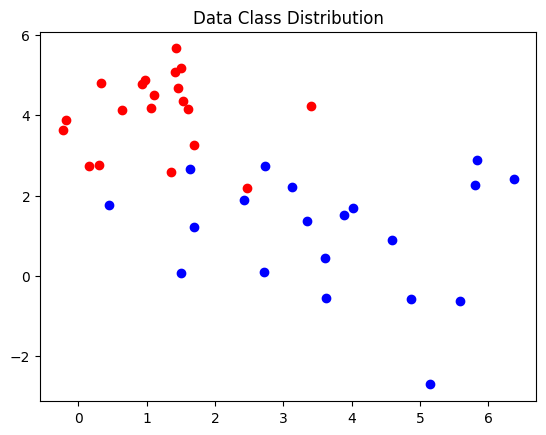

In [81]:
mean1, cov1 = [1, 4], [[1, 0], [0, 1]]
mean2, cov2 = [4, 1], [[2, 0], [0, 2]]

# Draw 20 points from each distribution
x1, y1 = np.random.multivariate_normal(mean1, cov1, 20).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, 20).T

# Plot the points
plt.scatter(x1, y1, color='red')
plt.scatter(x2, y2, color='blue')
plt.title('Data Class Distribution')
plt.show()

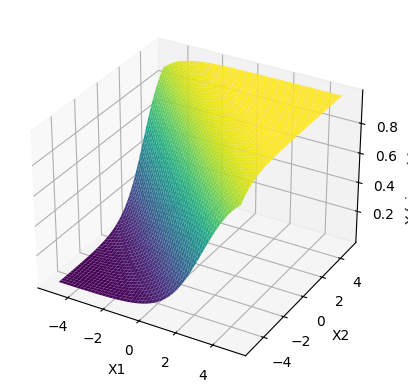

In [162]:
### VISUALIZE OUR ACTIVATION FUNCTION ### 

def sigmoid(x, w):
    x = np.dot(x, w)
    return 1 / (1 + np.exp(-x))

def plot_output_layer(w):
    x1 = np.linspace(-5, 5, 100)
    x2 = np.linspace(-5, 5, 100)

    X1, X2 = np.meshgrid(x1, x2)
    X3 = np.ones(X1.shape)  # bias term

    X = np.stack([X1, X2, X3], axis=-1)
    Z = sigmoid(X, w)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y (sigmoid output)')

    plt.show()

#   VARY WEIGHTS TO SEE HOW GRAPH RESPONDS (last one is bias)
plot_output_layer(np.array([1, 1, 2]))

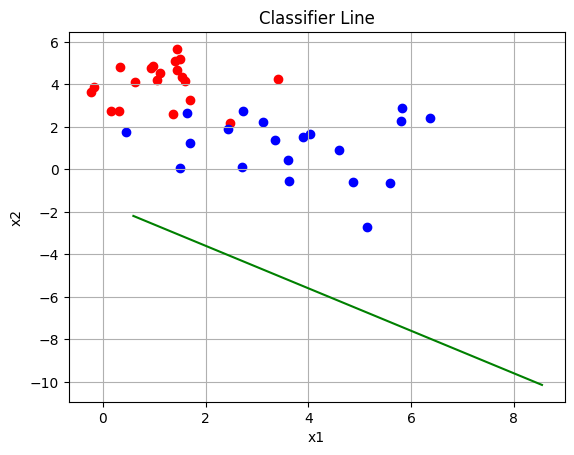

[-4.80195692  0.33351333  2.00005312]


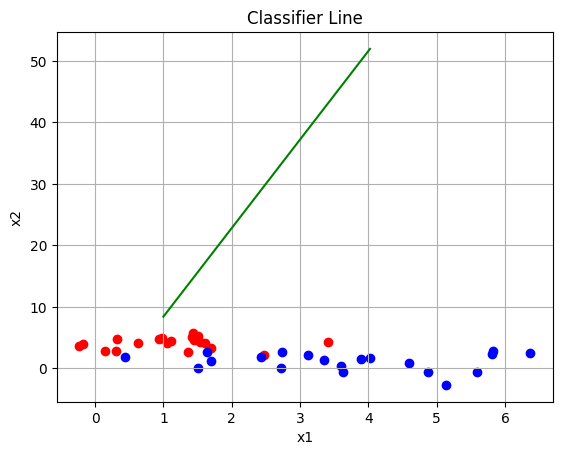

In [163]:
### TRAINING THE MODEL FOR ONE EPOCH AND OBSERVING OUR CLASSIFICATION LINE###
import random 

learning_rate = 0.1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(y ,t):
    return -t * np.log(y) - (1 - t) * np.log(1 - y)

def calc_gradient(y, t, x):
    dL_dw = (y - t) * x
    return dL_dw

def plot_classifier(x1, y1, x2, y2, w, x):
    """
    For each iteration of our weights, we can plot the classifier line with our 
    original distribution 
    """
    line = (-w[0] * x - w[2]) / w[1]
    plt.scatter(x1, y1, color='red')
    plt.scatter(x2, y2, color='blue')

    # Plot the line
    plt.plot(x, line, '-g')

    plt.title('Classifier Line')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid()
    plt.show()

# add extra dimension for the bias term
train_data_1 = zip(x1, y1, np.ones(20), np.ones(20))
train_data_0 = zip(x2, y2, np.ones(20), np.zeros(20))

# Combine the two classes into a single dataset
train_data = list(train_data_1) + list(train_data_0)
random.shuffle(train_data)

# x for plotting 
x = np.linspace(min(x1+x2), max(x1+x2), 100)

# Initialize the weights to something random
w = np.array([2.5, 2.5, 4])

# take a view at our classifier with random weights
plot_classifier(x1, y1, x2, y2, w, x)

dL_dw = np.zeros(3)
for sample in train_data:
    x = np.array(sample[:3])
    t = sample[3]
    y = sigmoid(np.dot(w, x))
    dL_dw += calc_gradient(y, t, x)

w -= learning_rate * dL_dw
print(w)
plot_classifier(x1, y1, x2, y2, w, x)





Ok now that we have got the idea of how it works, lets functionalize our training loop and run it for several epochs. At the end of each epoch I will plot the classification line, and we should see it improving each time. 

Additionally, we track our loss and the magnitude of the gradient vector at each iteration so we can
see how these evolve over time. If we are reaching a minimum (with respect to loss) both should be decreasing
over time. 

Weights at begining of iteration 0 = [2.5 2.5 4. ]


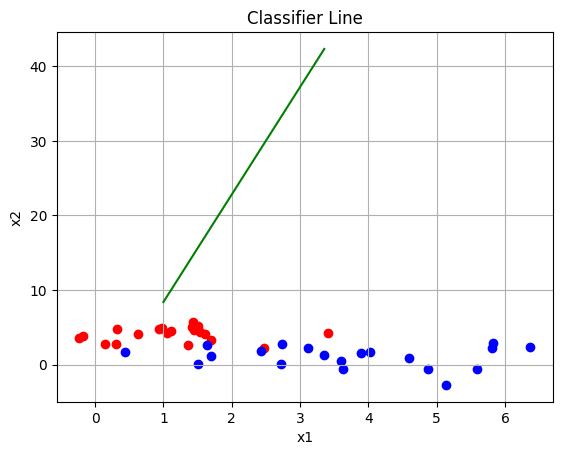

Weights at begining of iteration 1 = [-4.80195692  0.33351333  2.00005312]


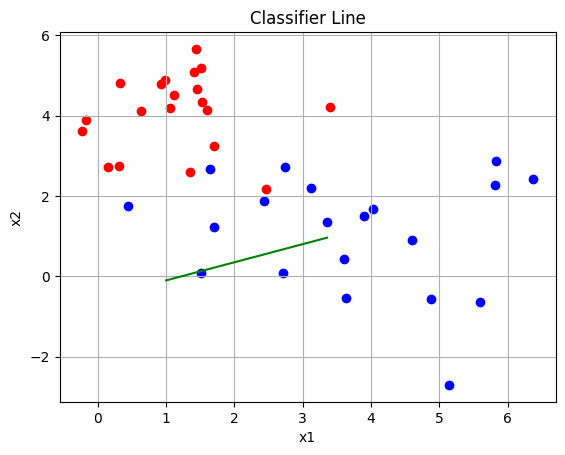

Weights at begining of iteration 2 = [-2.71655946  6.02051248  3.3162582 ]


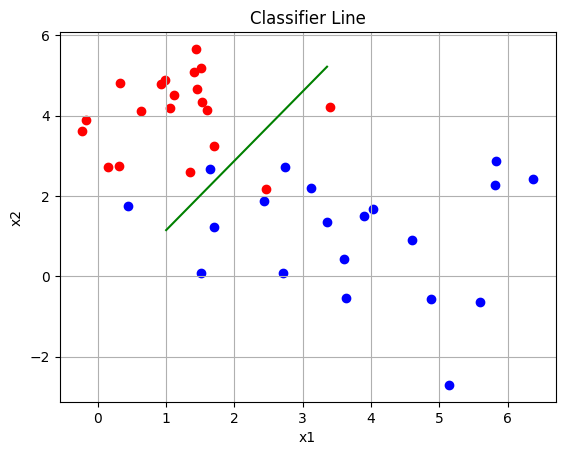

Weights at begining of iteration 3 = [-6.46387784  3.73995606  2.15591769]


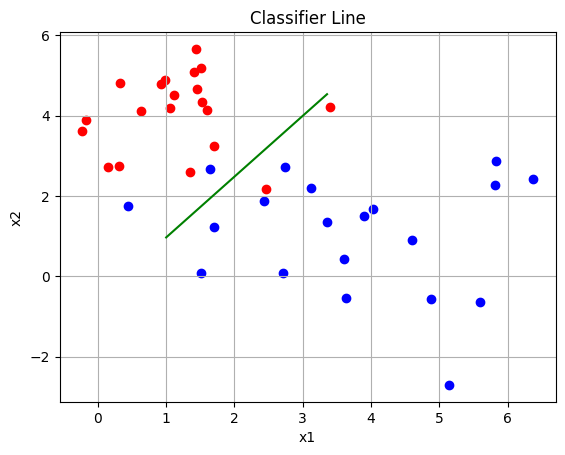

Weights at begining of iteration 4 = [-6.055004    3.99734853  2.17764631]


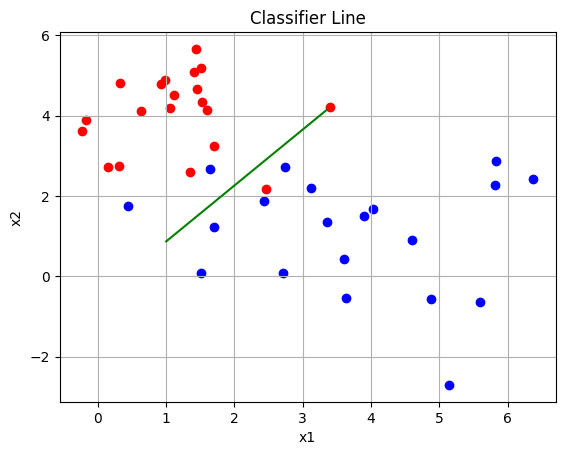

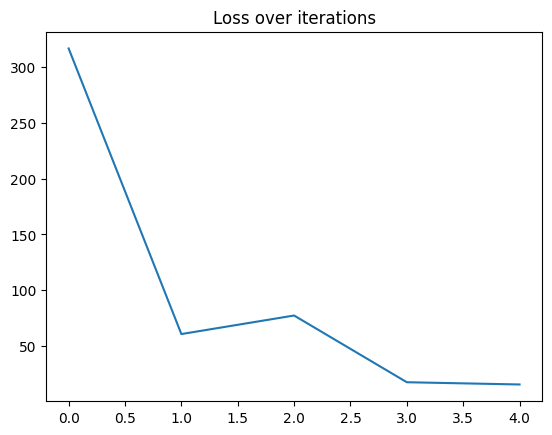

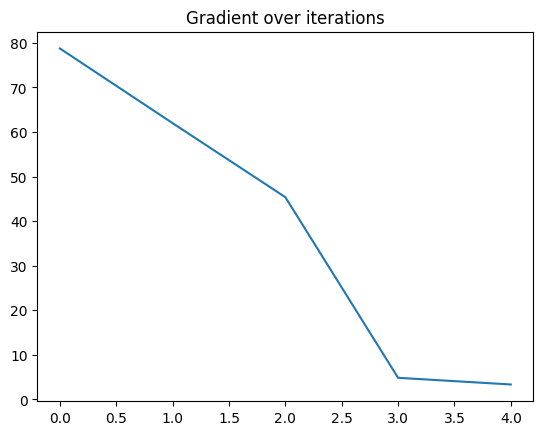

In [91]:
def run_epoch(w, train_data):
    # zero out gradient for each epoch 
    dL_dw = np.zeros(3)
    L = 0
    # loop through each sample in the dataset and accumulate gradient 
    for sample in train_data:
        x = np.array(sample[:3])
        t = sample[3]
        y = sigmoid(np.dot(w, x))
        L += loss(y, t)  # accumulate loss 
        dL_dw += calc_gradient(y, t, x)  # accumulate gradient 

    w -= learning_rate * dL_dw
    return w, L, dL_dw

def training_loop(w, train_data, iterations):
    loss, gradient = [], []
    for i in range(iterations):
        print(f"Weights at begining of iteration {i} = {w}")
        w, L, dL_dw = run_epoch(w, train_data)
        loss.append(L)
        gradient.append(np.sqrt((dL_dw**2).sum()))  # add magnitude of gradient
        plot_classifier(x1, y1, x2, y2, w, x)
    
    return loss, gradient

w = np.array([2.5, 2.5, 4])
loss, gradient = training_loop(w, train_data, 5)

plt.plot(loss)
plt.title('Loss over iterations')
plt.show()

plt.plot(gradient)
plt.title('Gradient over iterations')
plt.show()

Pretty good for a single neuron consisting of three weights! As you can see the loss flattens out over time. 
We could run this for more iterations and track the delta in loss at each step, and then stop our training once our training loss fails to get lower from iteration to iteration. 

In a real world setting, you'd likely hold out some of the data points as 'validation testing' so at the end of each epoch you can test your validation loss and see how the network does at classifying previously unseen points. 

Last point - this of course could've been made more efficient with vectorized operations. Looping through the examples was an illustrative point so our code matched what the formulas looked like :)

### Uncertainty and Regularization ### 
Let's modify our previous training loop function a little bit so we can examine the trajectory our weights take. In order to better visualize the weight path we are also going to change the network to solve a different problem - curve fitting (regression) so we will now pass it 5 data points and hope that our network will create a function y(x) that describes the data points. 

For this we will change our loss function from cross entropy loss to MSE which takes the form 
$$
L = \sum_{i=1}^{N} \frac{(t_i- y_i)^{2}}{2}
$$

We are also going to create our first real network, which is now a collection of neurons in a _hidden layer_ , each with their own weights, that will go through an activation, and a final neuron that will take 1 input from our K unit hidden layer and output a single value. 
For this problem we'll use a 25 unit hidden layer. So the input will be data points (x, t) with t being the y value that we want our network to output.  

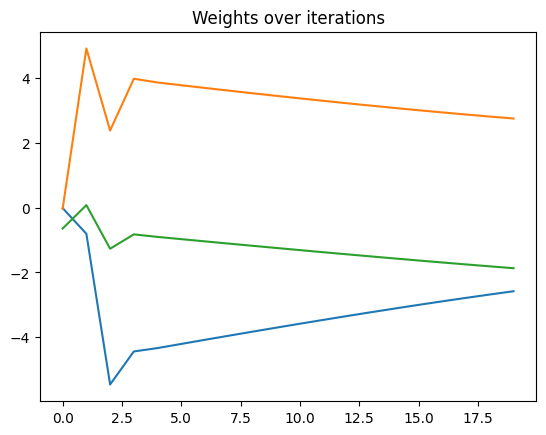

In [100]:
def loss(y ,t):
    return np.mean(((y-t)**2) / 2)

def calc_gradient(y, t, x):
    dL_dw = (y - t) * x
    return dL_dw

def forward_pass(X, W1, W2, b1, b2):
    """vectorized forward pass for a single layer neural network"""
    H1 = sigmoid(X @ W1.T + b1)  # n x 25
    y_hat = H1 @ W2  + b2 # n x 1
    return y_hat, H1

def run_epoch(X, W1, W2, t):
    """vectorized version of running a full epoch using full batch gradient descent"""
    H1, y_hat = forward_pass(X, W1, W2)
    L = loss(y_hat, t)  # loss for all samples 
    dL_dDW2 = X.T @ (y_hat - t)  # gradient for all samples
    W1 -= learning_rate * dL_dw
    return W1, L, dL_dw

def training_loop(w, train_data, iterations):
    loss, gradient = [], []
    weights = {'w1': [], 'w2': [], 'bias': []}
    for i in range(iterations):
        weights['w1'].append(w[0])
        weights['w2'].append(w[1])
        weights['bias'].append(w[2])
        w, L, dL_dw = run_epoch(w, train_data)
        loss.append(L)
        gradient.append(np.sqrt((dL_dw**2).sum()))  # add magnitude of gradient
    
    return loss, gradient, weights

# Set a random seed for reproducibility
np.random.seed(0)

# Generate 5 x values between -10 and 10
x = np.linspace(-10, 10, 5)

# Generate y values that follow a sine wave with some noise
y = np.sin(x) + np.random.normal(0, 0.5, size=x.shape)

X = np.stack([x, np.ones(x.shape)], axis=-1)
W1 = np.random.rand(2, 25)
W2 = np.random.rand(25, 1)


# plt.plot(weights['w1'], label='w1')
# plt.plot(weights['w2'], label='w2')
# plt.plot(weights['bias'], label='bias')
# plt.title('Weights over iterations')
# plt.show()

### Learning as Communication ###
TODO

### Learning as Inference ### 
Let's return to our regularized objective function for a binary classification task where we use CE loss, which we will denote $G(w)$ and the regularization (L2 norm) will be $\alpha * E_W(w)$ 
$$
M(w) = G(w) + \alpha * E_W(w)
$$

To make things simple and give us the ability to visualize here, we are going to go back to our single neuron example. With the single neuron, after sigmoid activation, we can view the outputs y as $P(t=1 | x, w)$ for some hypothesis w. So with y being the output of our neuron, we get the following equations 
$$
P(t=1 | x, w) = y
$$
$$
P(t=1 | x, w) = 1-y
$$ 

Thus we can combine this as $P(t | w, x) = y^t(1-y)^{1-t}$ which we can also express as $exp(t*ln(y) + (1-t)*(ln(1-y))) $. This should look familiar to you, as it is the negative exponent of our CE loss, and if we consider our data D to be our targets, we get 
$$
P(D | x, w) = exp(-G(w))
$$

So in Bayesian terms, we have our likelihood function, and now we need to get a prior. Well for that we can look at the second term in our objective function $M(w)$ and see that $P(w | a) = \frac{1}{Z_W(a)}\exp{-\alpha E_W}$. With $E_W$ being quadratic, the corresponding prior distribution is a Gaussian with variance $\sigma_w = \frac{1}{\alpha}$ and $\frac{1}{Z_W(\alpha)} = (\frac{\alpha}{2 \pi})^{K/2}$ where K is the dimensionality of w.

Putting it together, we arrive at the following equation for the posterior probability of the weights given our data (and alpha). 
$$
P(w | D, \alpha) = \frac{P(D|w) * P(w | \alpha)}{P(D | \alpha)}
$$
$$
 = \frac{e^{-G(w)}e^{-\alpha E_W(W)}}{Z_W(\alpha) * P(D|\alpha)}
$$
$$
= \frac{1}{Z_M}e^{-M(w)}
$$

Now we have a new way to look at our objective function and training of the neural net - the big takeways are:
1. The w found by locally minimizing M(w) can be viewed as the most probable parameter vector w
2. The Bayesian approach is to view learning as an _ensemble_ of plausible parameter values, w

But we still have one rather large problem. In order to consider the possibilities over all w, we need to marginalize it. Which means we need to solve a rather nasty integral, which represents the average of the output of the neuron at $x^{N+1}$ under the posterior distribution of w: 
$$
P(t^{(N+1)}=1 | \mathbf{x}^{(N+1)}, \mathbf{D}, \alpha) = \int d\mathbf{w} \, y(\mathbf{x}^{(N+1)}; \mathbf{w}) \, P(w | D, \alpha),
$$

Yuck. The good news is we know how to sample from potentially nasty distributions in multiple ways - any of the Monte Carlo techniques we previously learned for example!   
  
#### Takeaway ####
- The goal is to get enough samples from the posterior of $w$, $P(w | D, \alpha)$ that we can then compute the average output y under our w distribution. 

What we are going to do is return to our single neuron model, and this time use [_Langevin Monte Carlo_](https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/) method to sample from w and update our weights. Basically it's gradient descent + noise, with some acceptance/rejection criteria along the way. This should give us some samples from the posterior w

In [148]:
import numpy as np

def sigmoid(z):
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))


epsilon = 1e-7  # Small constant
def loss(y, t):
    y = np.clip(y, epsilon, 1 - epsilon)
    return -t * np.log(y) - (1 - t) * np.log(1 - y)

def calc_gradient(y, t, x):
    dL_dw = np.dot(x.T, (y - t))
    return dL_dw

def log_posterior(w, data, targets, alpha):
    y = sigmoid(np.dot(data, w))
    ce_loss = - np.sum(loss(y, targets))
    log_prior = - (alpha / 2) * np.sum(w ** 2)
    return -ce_loss + log_prior


def log_posterior_gradient(w, data, targets, alpha):
    y = sigmoid(np.dot(data, w))
    grad_loss = calc_gradient(y, targets, data)
    grad_prior = -alpha * w  # gradient of regularizer (our log prior here)
    return grad_loss + grad_prior

def generate_data(m1, m2, cov1, cov2, n=20):
    # Draw 20 points from each distribution
    x1_1, x2_1 = np.random.multivariate_normal(m1, cov1, n).T
    x1_2, x2_2 = np.random.multivariate_normal(m2, cov2, n).T

    # add extra dimension for the bias term and value for t
    train_data_1 = np.column_stack((x1_1, x2_1, np.ones(n), np.ones(n)))
    train_data_0 = np.column_stack((x1_2, x2_2, np.ones(n), np.zeros(n)))

    # Combine the two classes into a single dataset
    train_data = np.vstack((train_data_1, train_data_0))
    random.shuffle(train_data)
    return train_data[:, :3], train_data[:, 3 ]

# define our distributions and generate data 
mean1, cov1 = [1, 4], [[1, 0], [0, 1]]
mean2, cov2 = [4, 1], [[2, 0], [0, 2]]
n  = 20

X, t = generate_data(mean1, mean2, cov1, cov2, n)

# Initialize weights
w = np.random.randn(3) 

# LMC parameters
epsilon = 0.03  # Learning rate
alpha = 0.1  # Regularization strength
num_iterations = 10000

current_log_posterior = log_posterior(w, X, y, alpha)

weights_mc = []
acceptance_count = 0

for i in range(num_iterations):
    # Compute gradient of the log-posterior
    grad_log_posterior = log_posterior_gradient(w, X, t, alpha)
    
    # Update weights with gradient and noise
    noise = np.random.normal(0, np.sqrt(epsilon), size=w.shape)
    w_new = w - (epsilon / 2) * grad_log_posterior + noise
    
    new_log_posterior = log_posterior(w_new, X, t, alpha)
    # Accept or reject the new weights
    # TODO: add in plotting of the log posterior as we go 
    acceptance_ratio = np.exp(new_log_posterior - current_log_posterior)
    if np.random.rand() < min(1, acceptance_ratio):
        acceptance_count += 1
        w = w_new
        current_log_posterior = new_log_posterior
    
    if i % 100 == 0:
        weights_mc.append(w)
# w contains a sample from the posterior distribution

print(f"Acceptance ratio: {acceptance_count / num_iterations}")


Acceptance ratio: 0.7231


Great, we ran 10,000 iterations and every 100 pulled out a sample. After fiddling with epsilon, we got an acceptance ratio of 72%. Let's visualize our samples in weight space:

Text(0, 0.5, 'w2')

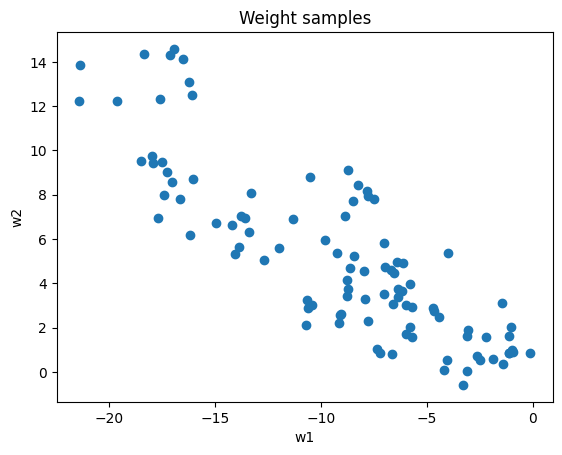

In [152]:
w1 = [w[0] for w in weights_mc]
w2 = [w[1] for w in weights_mc]

plt.scatter(w1, w2)
plt.title('Weight samples')
plt.xlabel('w1')
plt.ylabel('w2')


Nice - let's now make a cool visualization. We are going to calculate our prediction, y, over many data points x with all of our weight samples w for each x, then we will average each prediction and that will be the $P(t = 1 | x, w)$ for that point. This will essentially give us the marginalized distribution (over w) we were seeking in the first place. We can then plot our actual data points on it and view how we would look at them from the bayesian perspective !

w1 min and max = -0.06257299247440518, 6.767502018205509
w2 min and max = -0.3310447252022646, 5.408787257136309


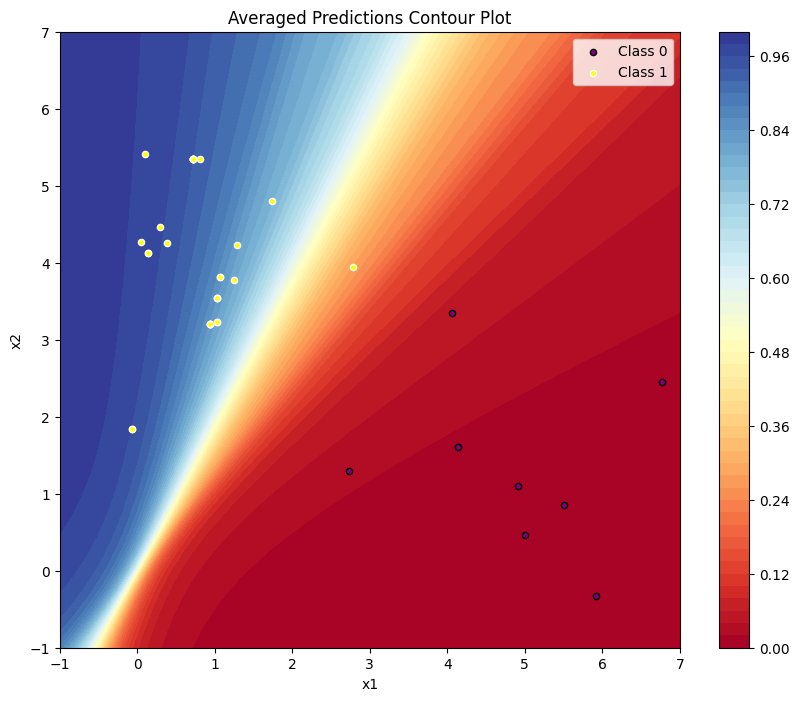

In [161]:
print(f"w1 min and max = {X[:, 0].min()}, {X[:, 0].max()}")
print(f"w2 min and max = {X[:, 1].min()}, {X[:, 1].max()}")

xx, yy = np.meshgrid(np.linspace(-1, 7, 100),
                     np.linspace(-1, 7, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

predictions = np.array([sigmoid(np.dot(grid, w[:2]))for w in weights_mc])
average_predictions = np.mean(predictions, axis=0)

average_predictions_reshaped = average_predictions.reshape(xx.shape)

plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, average_predictions_reshaped, levels=50, cmap="RdYlBu")
plt.colorbar(contour)

class_0 = X[t == 0]
class_1 = X[t == 1]

plt.scatter(class_0[:, 0], class_0[:, 1], c='purple', label='Class 0', edgecolors='black', s=20)
plt.scatter(class_1[:, 0], class_1[:, 1], c='yellow', label='Class 1', edgecolors='white', s=20)

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Averaged Predictions Contour Plot')
plt.show()

Pretty neat - we can now get a measure of 'confidence' of our predictions, which is a large improvement over our original binary classification line, albeit with some additional computation required. 